In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2020-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Barrier Synchronization Testing
This tutorial applies NxSDK performance benchmarking tools to a test of barrier synchronization.

## Understanding Barrier Synchronization Constraints
Each Loihi Chip consists of 3 Lakemont processors, and 4 by 8 grid of Neurocore tiles, with each tile containing 4 Neurocores. A Nahuku32 system has 32 Loihi Chips, but a model running on Nahuku32 may only require a small fraction of the Loihi Chips, or even a small fraction (a few cores) of 1 Loihi chip.

All Chips required to run a model (all chips simulating at least 1 neuron from the model) must synchronize their timesteps with each other through barrier synchronization. 

Barrier synchronization must operate on a rectangular arrangement of Chips. 

After compilation, NxSDK knows which Chips are required by the model, and a rectangular barrier synchronization region is defined which encompasses all required Chips. Is is possible that some Chips with no neurons fall within the barrier synchronization rectangle, in which case those Chips must also participate in barrier synchronization.

For example, if 11 chips (0 to 10) of a Nahuku32 board are required to run a model, then 16 chips (0 to 15) will be part of barrier sync.

![Barrier Sync Chips](figures/barrier_sync_chips.png)

For each Chip within the barrier synchronization region, an internal (in-chip) rectangular barrier synchronization region must be defined which encompasses Lakemont 0, any Lakemonts running snips, and any Neurocores which have at least 1 neuron. In-chip barrier synchronization is defined at the scale of tiles (either all 4 cores in a tile participate, or none), and all Neurocores within the in-chip barrier synchronization region must participate, and all Neurocores participating in barrier sync must be fully powered.

For example, a model requiring 40 cores (core 0 to 39) would occupy the red tiles in the image below. Lakemont 0 must also participate in barrier sync, so the blue region is defined.

![Barrier Sync Cores](figures/barrier_sync_cores.png)

Loihi's power saving features include clock gating all Lakemonts which aren't participating in barrier synchronization, and powering down all Neurocores which aren't participating in barrier synchronization.

## Test Design
To run the test, we specify a number of chips, and two cores addresses. The test places 2 neurons on each chip, one at each core address. During compilation, NxSDK will define the inter-chip barrier sync region as well as each in-chip barrier sync region. An init phase snip turns off the 2 neurons on each chip before the run starts, so we end up just running an empty model with no neurons.

In [2]:
from nxsdk_modules.characterization.src.characterization import *
from matplotlib import pyplot as plt
from nxsdk.logutils.nxlogging import set_verbosity, LoggingLevel
set_verbosity(LoggingLevel.WARNING)

In [3]:
#boardName='ncl-ext-ghrd-01'
boardName='ncl-ghrd-04'

## Single Chip Test
In the first test we use only a single chip. One neuron is placed in the bottom right tile, and the other neuron starts in the bottom left, and moves up one tile in each subsequent run. This means we'll start with a barrier sync region encompassing only the bottom row, and in each subsequent run will include 1 more row of tiles.

Running test with start core at address 0
Running test with start core at address 4
Running test with start core at address 8
Running test with start core at address 12


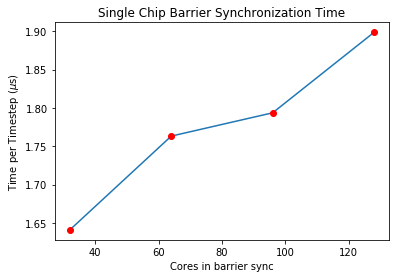

In [4]:
numCoresSynchronizedPerChip = []
timePerTimestep = []

numChips = 1
bsCoreEnd = 112
for bsCoreStart in range(0,16,4):
    print("Running test with start core at address {}".format(bsCoreStart))
    powerStats = testBarrierSync(runTime=100000,
                                    bsCores=[bsCoreStart,bsCoreEnd],
                                    numChips=numChips, 
                                    boardName=boardName)
    
    numCoresSynchronizedPerChip.append(powerStats.numCoresActuallyOn/powerStats.numChipsActuallyBeingUsed)
    timePerTimestep.append(powerStats.timePerTimestep)
    
plt.plot(numCoresSynchronizedPerChip, timePerTimestep)
plt.plot(numCoresSynchronizedPerChip, timePerTimestep, 'ro')
plt.title("Single Chip Barrier Synchronization Time")    
plt.xlabel("Cores in barrier sync")
plt.ylabel("Time per Timestep ($\mu$s)")
plt.show()

## Multi Chip Test
In the second test we keep the in-chip barrier synchronization region constant (bottom row only) for all active Lakemonts in each run and vary the number of chips.

Running test with 1 chips
Running test with 2 chips... s... 
Running test with 4 chips... s... 
Running test with 8 chips... s... 
Running test with 16 chips.. s... 
Running test with 24 chips.. s... 
Running test with 32 chips.. s... 


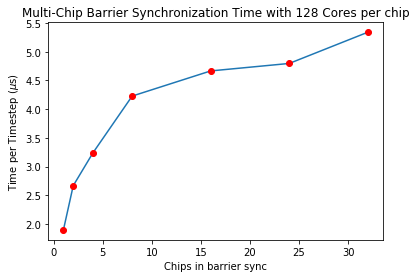

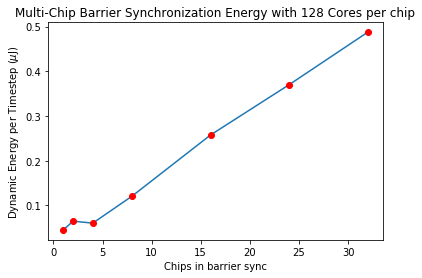

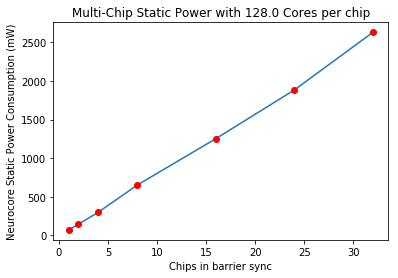

In [5]:
numCoresSynchronizedPerChip = []
numChipsSynchronized = []
timePerTimestep = []
neuroCoreDynamicEnergyPerTimestep = []
staticPower = []

bsCoreStart = 0
bsCoreEnd = 127
for numChips in [1,2,4,8,16,24,32]:
    print("Running test with {} chips".format(numChips))
    powerStats = testBarrierSync(runTime=100000,
                                 bsCores=[bsCoreStart,bsCoreEnd],
                                 numChips=numChips, 
                                 boardName=boardName)
    
    neuroCoreDynamicEnergyPerTimestep.append(powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3) #/1e3 to convert to uJ        
    numCoresSynchronizedPerChip.append(powerStats.numCoresActuallyOn/powerStats.numChipsActuallyBeingUsed)
    numChipsSynchronized.append(powerStats.numChipsActuallyBeingUsed)
    timePerTimestep.append(powerStats.timePerTimestep)
    
    # show the full power of all the cores involved in barrier synchronization
    staticPower.append(powerStats.power['core']['static']*powerStats.numCoresActuallyOn/powerStats.numCores)

plt.plot(numChipsSynchronized, timePerTimestep)
plt.plot(numChipsSynchronized, timePerTimestep, 'ro')
plt.title("Multi-Chip Barrier Synchronization Time with {:.0f} Cores per chip".format(numCoresSynchronizedPerChip[0]))    
plt.xlabel("Chips in barrier sync")
plt.ylabel("Time per Timestep ($\mu$s)")
plt.show()

plt.plot(numChipsSynchronized, neuroCoreDynamicEnergyPerTimestep)
plt.plot(numChipsSynchronized, neuroCoreDynamicEnergyPerTimestep, 'ro')
plt.title("Multi-Chip Barrier Synchronization Energy with {:.0f} Cores per chip".format(numCoresSynchronizedPerChip[0]))    
plt.xlabel("Chips in barrier sync")
plt.ylabel("Dynamic Energy per Timestep ($\mu$J)")
plt.show()

plt.plot(numChipsSynchronized, staticPower)
plt.plot(numChipsSynchronized, staticPower, 'ro')
plt.title("Multi-Chip Static Power with {} Cores per chip".format(numCoresSynchronizedPerChip[0]))    
plt.xlabel("Chips in barrier sync")
plt.ylabel("Neurocore Static Power Consumption (mW)")
plt.show()